In [ ]:
%matplotlib inline

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from os.path import normpath, basename
from skimage import io, transform
from PIL import Image

plt.ion()   # interactive mode

In [6]:
class TextureDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        path = os.path.dirname(os.path.dirname(self.root_dir))
        self.classes = os.listdir(path)

    def __len__(self):
        lista = os.listdir(self.root_dir)
        return len(lista)

    def __getitem__(self, idx):
        lista = os.listdir(self.root_dir)
        img_name = os.path.join(self.root_dir, lista[idx])
        image = io.imread(img_name)
        img = Image.fromarray(image)
        path = os.path.dirname(self.root_dir)
        label = basename(normpath(path))
        label = self.classes.index(label)

        if self.transform:
            img = self.transform(img)

        return (img, label)
    
    def classes(self):

        return self.classes

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

root = r'D:\Google Drive\UNICAMP\IC\KTH-TIPS\KTH-TIPS2-a'
classes = os.listdir(root)
data_dir = []
image_datasets = {'train': [] , 'val': []}

for i in range(len(classes)):
    data_dir.append(os.path.join(root,classes[i]))
    
subclasses = os.listdir(data_dir[0]) # Para que funcione, todas as classes devem ter o mesmo numero de subclasses

val_samp = 'sample_a'
train_samp = subclasses[:]
train_samp.remove(val_samp)
    
for i in range(len(classes)):
    image_datasets['val'].append(TextureDataset(os.path.join(data_dir[i], val_samp), data_transforms['val']))
    for j in range(len(train_samp)):
        image_datasets['train'].append(TextureDataset(os.path.join(data_dir[i], train_samp[j]), data_transforms['train']))

image_datasets = {x: torch.utils.data.ConcatDataset(image_datasets[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(image_datasets['train'].__getitem__(200))
print(image_datasets['val'].__getitem__(1100))
print(image_datasets['train'].__len__())
print(image_datasets['val'].__len__())

(tensor([[[ 0.0056,  0.0056, -0.0629,  ..., -0.1143, -0.1143, -0.1143],
         [ 0.0056,  0.0056, -0.0629,  ..., -0.1143, -0.1143, -0.1143],
         [-0.0458, -0.0458, -0.0972,  ..., -0.1314, -0.0972, -0.0972],
         ...,
         [-0.6794, -0.6794, -0.6794,  ...,  1.3242,  1.9578,  1.9578],
         [-0.6623, -0.6623, -0.6623,  ...,  1.4783,  2.1290,  2.1290],
         [-0.6623, -0.6623, -0.6623,  ...,  1.4783,  2.1290,  2.1290]],

        [[ 0.0476,  0.0476, -0.0224,  ..., -0.0049, -0.0049, -0.0049],
         [ 0.0476,  0.0476, -0.0224,  ..., -0.0049, -0.0049, -0.0049],
         [ 0.0126,  0.0126, -0.0574,  ..., -0.0224,  0.0126,  0.0126],
         ...,
         [-0.5476, -0.5476, -0.5476,  ...,  1.6583,  2.2885,  2.2885],
         [-0.5126, -0.5126, -0.5126,  ...,  1.7983,  2.4286,  2.4286],
         [-0.5126, -0.5126, -0.5126,  ...,  1.7983,  2.4286,  2.4286]],

        [[ 0.1651,  0.1651,  0.0953,  ...,  0.1825,  0.1825,  0.1825],
         [ 0.1651,  0.1651,  0.0953,  ...,  

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



tensor([[[[ 0.3309,  0.3309,  0.3481,  ...,  0.2282,  0.2282,  0.2282],
          [ 0.3309,  0.3309,  0.3481,  ...,  0.2453,  0.2282,  0.2282],
          [ 0.3481,  0.3481,  0.3652,  ...,  0.2624,  0.2624,  0.2624],
          ...,
          [ 0.2111,  0.2111,  0.2282,  ...,  0.1597,  0.1768,  0.1768],
          [ 0.2453,  0.2453,  0.2453,  ...,  0.1768,  0.1939,  0.1939],
          [ 0.2453,  0.2453,  0.2624,  ...,  0.1939,  0.2111,  0.2111]],

         [[-0.0399, -0.0399, -0.0224,  ..., -0.2325, -0.2325, -0.2325],
          [-0.0224, -0.0399, -0.0224,  ..., -0.2150, -0.2150, -0.2150],
          [-0.0049, -0.0049, -0.0049,  ..., -0.1625, -0.1800, -0.1800],
          ...,
          [-0.2500, -0.2500, -0.2675,  ..., -0.2850, -0.2675, -0.2675],
          [-0.2325, -0.2325, -0.2500,  ..., -0.2850, -0.2675, -0.2675],
          [-0.2325, -0.2325, -0.2500,  ..., -0.2850, -0.2675, -0.2675]],

         [[-0.8633, -0.8807, -0.9330,  ..., -0.8110, -0.8110, -0.8110],
          [-0.8633, -0.8633, -

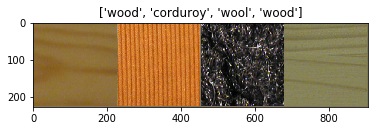

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#print (next((iter(dataloaders['train']))))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
#inputs, classes = image_datasets['train'].__getitem__(200)

print (inputs)
print (classes)
print (class_names)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
#imshow(out)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9203 Acc: 0.7047
val Loss: 1.0894 Acc: 0.6473

Epoch 1/24
----------
train Loss: 0.5820 Acc: 0.8155
val Loss: 1.5906 Acc: 0.7256

Epoch 2/24
----------
train Loss: 0.3937 Acc: 0.8784
val Loss: 1.1095 Acc: 0.7786

Epoch 3/24
----------
train Loss: 0.3417 Acc: 0.8962
val Loss: 1.0936 Acc: 0.7929

Epoch 4/24
----------
train Loss: 0.2688 Acc: 0.9187
val Loss: 1.0258 Acc: 0.7694

Epoch 5/24
----------
train Loss: 0.2347 Acc: 0.9275
val Loss: 1.2917 Acc: 0.7761

Epoch 6/24
----------
train Loss: 0.2650 Acc: 0.9219
val Loss: 1.8965 Acc: 0.7492

Epoch 7/24
----------
train Loss: 0.1383 Acc: 0.9596
val Loss: 1.2480 Acc: 0.7727

Epoch 8/24
----------
train Loss: 0.0994 Acc: 0.9740
val Loss: 1.7317 Acc: 0.7374

Epoch 9/24
----------
train Loss: 0.0938 Acc: 0.9737
val Loss: 1.6971 Acc: 0.7492

Epoch 10/24
----------
train Loss: 0.0917 Acc: 0.9719
val Loss: 1.5912 Acc: 0.7652

Epoch 11/24
----------
train Loss: 0.0766 Acc: 0.9789
val Loss: 1.6108 Acc: 0.7635

Ep

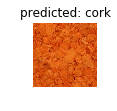

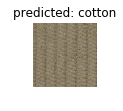

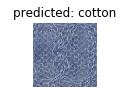

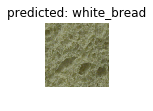

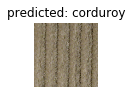

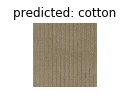

In [17]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 11)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0948 Acc: 0.6401
val Loss: 0.6271 Acc: 0.7424

Epoch 1/24
----------
train Loss: 0.7521 Acc: 0.7526
val Loss: 0.8066 Acc: 0.7163

Epoch 2/24
----------
train Loss: 0.7360 Acc: 0.7652
val Loss: 0.8856 Acc: 0.7222

Epoch 3/24
----------
train Loss: 0.6614 Acc: 0.7731
val Loss: 0.9643 Acc: 0.7205

Epoch 4/24
----------
train Loss: 0.6491 Acc: 0.7854
val Loss: 1.2386 Acc: 0.7357

Epoch 5/24
----------
train Loss: 0.6346 Acc: 0.7921
val Loss: 1.0393 Acc: 0.7382

Epoch 6/24
----------
train Loss: 0.6421 Acc: 0.7991
val Loss: 1.1326 Acc: 0.7382

Epoch 7/24
----------
train Loss: 0.5315 Acc: 0.8289
val Loss: 0.7605 Acc: 0.7542

Epoch 8/24
----------
train Loss: 0.5118 Acc: 0.8401
val Loss: 1.1066 Acc: 0.7290

Epoch 9/24
----------
train Loss: 0.5301 Acc: 0.8368
val Loss: 0.9040 Acc: 0.7382

Epoch 10/24
----------
train Loss: 0.5058 Acc: 0.8363
val Loss: 0.8039 Acc: 0.7551

Epoch 11/24
----------
train Loss: 0.5238 Acc: 0.8404
val Loss: 1.0305 Acc: 0.7088

Ep

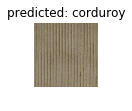

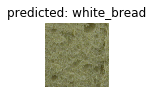

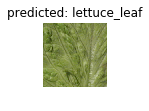

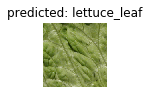

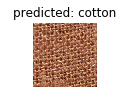

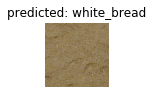

In [22]:
visualize_model(model_conv)

plt.ioff()
plt.show()